
# Genetikus algoritmusok – **Szelekciós módszerek** (HU)

Ebben a jegyzetben a leggyakoribb szelekciós eljárásokat fogjuk gyakorolni:

- **Fitness arányos (rulettkerék)**
- **Tournament szelekció (k-fős verseny)**
- **Rang alapú szelekció**
- **Elitizmus**

Házi feladat extra pontokért:

- **Boltzmann / sztochasztikus szelekció** (Bónusz feladat)
- **Truncation (csonkolás)** (Bónusz feladat))


**Labor célja:** az evolúciós nyomás és diverzitás **egyensúlyának** bemutatása, valamint a módszerek **előnyeinek / hátrányainak** megértése.


In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
random.seed(7)
np.random.seed(7)



## 0) Oktatási minta-populáció

Az alábbi **kis populáció** segít szemléltetni a módszerek viselkedését. A fitness értékeket úgy választjuk, hogy legyenek **extrém különbségek** is (hogy lássuk a torzító hatást).

- Populáció méret: `N = 10`
- Fitness: néhány nagyon jó, több közepes, és 1–2 gyenge egyed


In [2]:

# Minta-populáció (azonosítók és fitness)
N = 10
ids = np.array([f"ind_{i}" for i in range(N)])

# Kézzel beállított, szemléltető fitnessek (extrém különbségekkel)
fitness = np.array([2, 5, 1, 30, 4, 3, 18, 0.5, 8, 0.2], dtype=float)

# Normalizáló segédfüggvények
def normalize_positive(x):
    # Eltolás, hogy minden érték >= 0 legyen
    m = np.min(x)
    if m < 0:
        x = x - m
    return x

def softmax_scaled(x, T=1.0):
    # Boltzmann valószínűségek: exp(x/T) normalizálva (numerikusan stabil)
    z = (x - np.max(x)) / max(T, 1e-8)
    e = np.exp(z)
    return e / np.sum(e)

print("Egyedek:", ids)
print("Fitness :", fitness)


Egyedek: ['ind_0' 'ind_1' 'ind_2' 'ind_3' 'ind_4' 'ind_5' 'ind_6' 'ind_7' 'ind_8'
 'ind_9']
Fitness : [ 2.   5.   1.  30.   4.   3.  18.   0.5  8.   0.2]


In [3]:

def plot_selection_counts(ids, counts, title):
    # Egyszerű oszlopdiagram: kiválasztási gyakoriságok
    plt.figure()
    x = np.arange(len(ids))
    plt.bar(x, counts)
    plt.xticks(x, ids, rotation=45, ha='right')
    plt.ylabel("Kiválasztások száma")
    plt.title(title)
    plt.tight_layout()
    plt.show()



## 1) Fitness arányos szelekció (rulettkerék)

**Ötlet:** az egyed kiválasztási valószínűsége arányos a fitness értékével.  
- **Előny:** egyszerű, intuitív.  
- **Hátrány:** **extrém** fitness különbségeknél **eltorzul**, a legjobb(ak) dominál(nak), **diverzitás csökkenhet**.

> Megjegyzés: negatív fitness esetén eltolást/normalizálást kell alkalmazni.


Rulettkerék valószínűségek (≈):
ind_0: p≈0.028
ind_1: p≈0.070
ind_2: p≈0.014
ind_3: p≈0.418
ind_4: p≈0.056
ind_5: p≈0.042
ind_6: p≈0.251
ind_7: p≈0.007
ind_8: p≈0.112
ind_9: p≈0.003


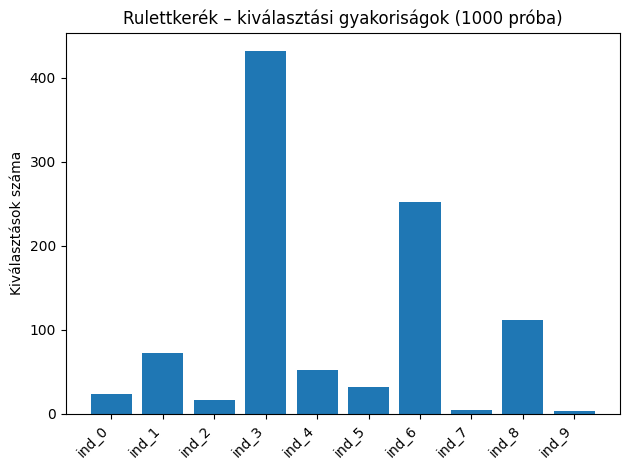

In [4]:

def roulette_wheel_selection(ids, fitness, n_select):
    f = normalize_positive(fitness.astype(float))
    total = np.sum(f)
    if total <= 0:
        # ha minden 0, uniform választás
        p = np.ones_like(f) / len(f)
    else:
        p = f / total
    # mintavétel visszatevéssel
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p

# Illusztráció: ismételt kiválasztások és gyakoriság diagram
n_trials = 1000
selected, probs = roulette_wheel_selection(ids, fitness, n_trials)
unique, counts = np.unique(selected, return_counts=True)

print("Rulettkerék valószínűségek (≈):")
for i, id_ in enumerate(ids):
    print(f"{id_}: p≈{probs[i]:.3f}")

# Grafikon
count_map = {u:c for u,c in zip(unique, counts)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])
plot_selection_counts(ids, counts_ordered, "Rulettkerék – kiválasztási gyakoriságok (1000 próba)")



## 2) Tournament szelekció (k-fős verseny)

**Ötlet:** minden kiválasztáshoz véletlenszerűen választunk `k` egyedet, és **közülük a legjobb** nyer.  
- **Előny:** **gyors**, **skálázható**, ritkábban zuhan túlzott szelekciós nyomásba.  
- **Paraméter:** a `k` növelése erősíti a szelekciós nyomást (kicsi `k` → több diverzitás).


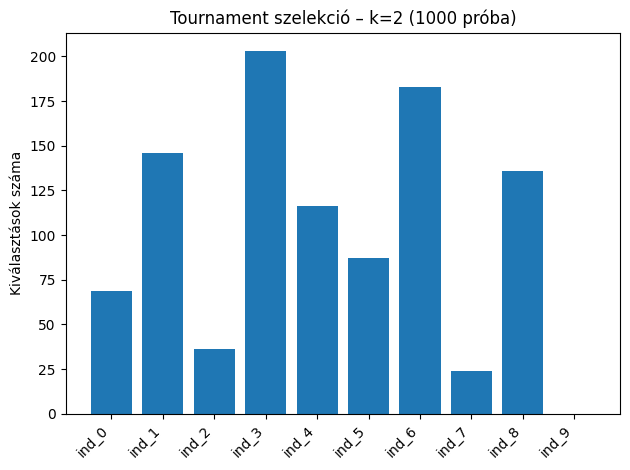

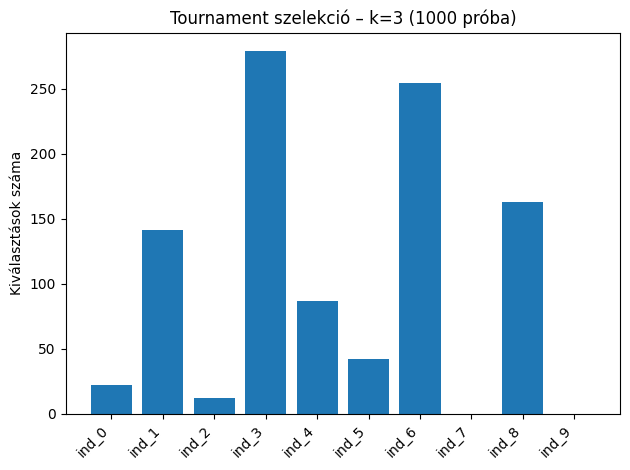

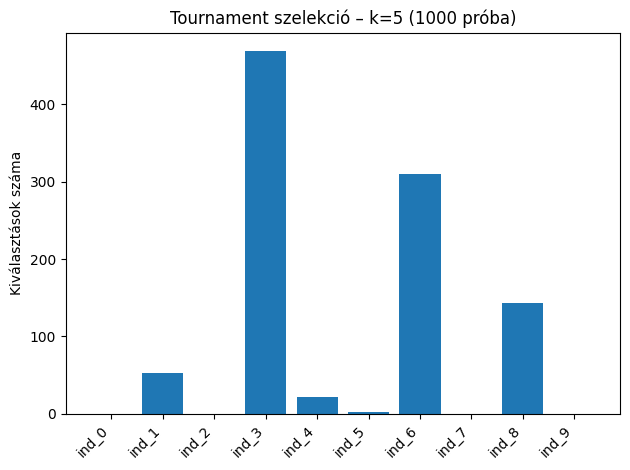

In [5]:

def tournament_selection(ids, fitness, n_select, k=3):
    chosen = []
    for _ in range(n_select):
        idxs = np.random.choice(len(ids), size=k, replace=False)
        best_idx = idxs[np.argmax(fitness[idxs])]
        chosen.append(ids[best_idx])
    return np.array(chosen)

# Hasonlítsuk össze különböző k értékekkel
for k in [2, 3, 5]:
    n_trials = 1000
    sel = tournament_selection(ids, fitness, n_trials, k=k)
    uniq, cnt = np.unique(sel, return_counts=True)
    count_map = {u:c for u,c in zip(uniq, cnt)}
    counts_ordered = np.array([count_map.get(i, 0) for i in ids])
    plot_selection_counts(ids, counts_ordered, f"Tournament szelekció – k={k} (1000 próba)")



## 3) Rang alapú szelekció

**Ötlet:** az egyedeket **rangsoroljuk** fitness szerint, és a kiválasztási esély a **ranghoz kötött**.  
- **Előny:** stabilizálja a szelekciót, **ellenálló** extrém fitness különbségeknél is (nem engedi túl-dominálni a csúcs értékeket).  
- **Megvalósítás:** pl. lineáris rangsúlyozás – a legjobb rang kapja a legnagyobb valószínűséget, de arányok kontrolláltak.


Rangsúlyok (legnagyobb a legjobb): [ 4  7  3 10  6  5  9  2  8  1]
Rang alapú valószínűségek (≈): [0.073 0.127 0.055 0.182 0.109 0.091 0.164 0.036 0.145 0.018]


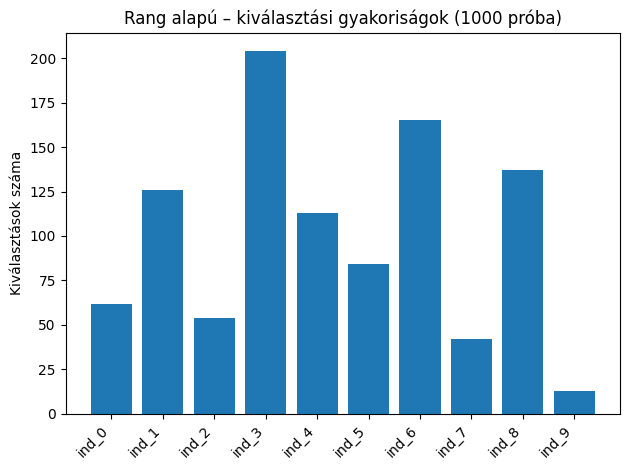

In [6]:

def rank_based_selection(ids, fitness, n_select):
    # Rangsorolás (nagyobb fitness -> jobb rang)
    order = np.argsort(-fitness)  # desc
    ranks = np.empty_like(order)
    ranks[order] = np.arange(len(ids), 0, -1)  # legjobb kapja a legnagyobb rangszámot

    # Lineáris valószínűség a ranghoz arányosan
    p = ranks / np.sum(ranks)
    chosen = np.random.choice(ids, size=n_select, replace=True, p=p)
    return chosen, p, ranks

n_trials = 1000
selected, p_rank, ranks = rank_based_selection(ids, fitness, n_trials)
uniq, cnt = np.unique(selected, return_counts=True)
count_map = {u:c for u,c in zip(uniq, cnt)}
counts_ordered = np.array([count_map.get(i, 0) for i in ids])

print("Rangsúlyok (legnagyobb a legjobb):", ranks)
print("Rang alapú valószínűségek (≈):", np.round(p_rank, 3))
plot_selection_counts(ids, counts_ordered, "Rang alapú – kiválasztási gyakoriságok (1000 próba)")



## 4) Elitizmus

**Ötlet:** a **legjobb** `E` egyed **garantáltan** átkerül a következő generációba.  
- **Előny:** a **legjobb megoldás** nem vész el.  
- **Hátrány:** túl erős elitizmus → **diverzitás csökken**, **lokális optimumhoz ragadhat**.

Az alábbi példa egyetlen generációt illusztrál: először elit másolás, majd a maradék helyek feltöltése (pl. rang alapú szelekcióval).


In [7]:

def elite_preservation(ids, fitness, E=2):
    # top-E indexek
    order = np.argsort(-fitness)
    elites = ids[order[:E]]
    return elites

def next_generation_with_elite(ids, fitness, pop_size=10, E=2):
    elites = elite_preservation(ids, fitness, E=E)
    remaining = pop_size - E
    selected, _, _ = rank_based_selection(ids, fitness, remaining)
    # új generáció (azonosítók szintjén bemutatva)
    new_gen = np.concatenate([elites, selected])
    return new_gen

new_gen = next_generation_with_elite(ids, fitness, pop_size=10, E=2)
print("Elitek:", elite_preservation(ids, fitness, E=2))
print("Új generáció (azonosítók):", new_gen)


Elitek: ['ind_3' 'ind_6']
Új generáció (azonosítók): ['ind_3' 'ind_6' 'ind_5' 'ind_4' 'ind_8' 'ind_8' 'ind_2' 'ind_1' 'ind_0'
 'ind_8']



## 5) Boltzmann / sztochasztikus szelekció

**Ötlet:** valószínűségek **hőmérsékletfüggők** – `p_i ∝ exp(fitness_i / T)`  
- **Magas T:** közel **egyenletes** kiválasztás → **nagy diverzitás**.  
- **Alacsony T:** a nagy fitness **dominál** → **erős nyomás**.

Gyakori stratégia: **hűtés** (T fokozatos csökkentése).



## 6) Truncation (csonkolás) szelekció

**Ötlet:** csak a **legjobb** `p%` kerülhet tovább, a többiek kiesnek.  
- **Előny:** **nagyon erős** szelekciós nyomás, gyors konvergencia.  
- **Hátrány:** **diverzitás** gyors elvesztése, könnyebb **lokális optimum**.

Az alábbi implementáció a top `p%` halmazból választ **visszatevéssel** (ha a populációt ugyanarra a méretre akarjuk feltölteni).



## 7) Kérdések és rövid, gyakorlati válaszok

**Mi a különbség a rulettkerék- és a tournament-szelekció között?**  
- Rulettkerék: valószínűség **arányos** a fitness-szel → **extrém értékek torzíthatnak**.  
- Tournament: mindig **k** jelölt versenyez, a **legjobb nyer** → paraméterezhető nyomás, **skálázható** és robusztusabb extrémekkel szemben.

**Miért előnyös a rang alapú szelekció extrém fitness különbségek esetén?**  
- Mert a kiválasztási esélyt **nem a nyers fitness**, hanem a **rang** határozza meg → **stabilabb**, nem engedi a túl-dominanciát.

**Milyen előnye és hátránya van az elitizmusnak?**  
- Előny: a **legjobb megoldás** nem vész el, **monoton** javulás biztosítható.  
- Hátrány: túl nagy elit arány → **diverzitás** csökken, **beszorulás** lokális optimumba.

**Mely szelekciós módszer illik legjobban a permutációs ábrázoláshoz?**  
- Gyakorlati tapasztalat szerint a **tournament** és **rang alapú** jól működik permutációknál, mert **robosztusabbak** az outlierekkel szemben és jól **skálázódnak**.

**Miért engednek néha a gyengébb egyedeknek is esélyt a szelekcióban?**  
- A **diverzitás** fenntartása miatt: a túl erős nyomás **korai konvergenciához** vezethet. Némi véletlen esély segít elkerülni a **lokális optimumot** és támogatja a **feltárást**.
